In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

In [4]:
train_df = pd.read_csv('train.csv')

# set up for further filtering
train_df['NameLength'] = train_df['Name'].str.len()
train_df['Cabin'] = train_df['Cabin'].astype(str)
train_df['Cabin'] = train_df['Cabin'].str[0] + train_df['Cabin'].str[-1]
train_df['total spending'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
train_df['VIP'] = train_df['VIP'].fillna(False).astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].fillna(False).astype(int)

# needed to calculate the distribution of positives to sort catagorical features
transported_true = train_df[train_df['Transported'] == True]

# sort homeplanet catagories by True values percentages
counts = train_df['HomePlanet'].value_counts()
transported_counts = transported_true.groupby('HomePlanet').size()
percentages = transported_counts/counts
homeplanet_map = percentages.sort_values(ascending=False)
planet_map = {planet: rank for rank, planet in enumerate(homeplanet_map.index)}
train_df['HomePlanet'] = train_df['HomePlanet'].map(planet_map)


# sort destination catagories by True values percentages
Destcounts = train_df['Destination'].value_counts()
transDest_counts = transported_true.groupby('Destination').size()
percent_vals = transDest_counts/Destcounts
dest_map = percent_vals.sort_values(ascending=False)
d_map = {planet: rank for rank, planet in enumerate(dest_map.index)}
train_df['Destination'] = train_df['Destination'].map(d_map)

# sort Cabin catagories by True values percentages
# This does not need to be divided by counts as in my previous notebook it is 
# shown that there is less than a 1% differance in size of groups
cabin_counts = train_df[train_df['Transported'] == True].groupby('Cabin').size()
sorted_cabins = cabin_counts.sort_values(ascending=False).index
cabin_mapping = {cabin: rank for rank, cabin in enumerate(sorted_cabins)}
train_df['Cabin_ordinal'] = train_df['Cabin'].map(cabin_mapping).fillna(-1).astype(int)


# Targets
targets = train_df['Transported']


#drop unused Catagories
filtered_X = train_df[['HomePlanet', 'CryoSleep', 'Age','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','NameLength', 'total spending', 'Cabin_ordinal']]

filtered_X


,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NameLength,total spending,Cabin_ordinal
0,0.0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,6
1,2.0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,12.0,736.0,1
2,0.0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,13.0,10383.0,13
3,0.0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,12.0,5176.0,13
4,2.0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,17.0,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,17.0,8536.0,14
8689,2.0,1,18.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0
8690,2.0,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,12.0,1873.0,0
8691,0.0,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,16.0,4637.0,8


In [8]:
filtered_X = filtered_X.fillna(filtered_X.median())

In [11]:
nan_rows = filtered_X.isna().any(axis=1).sum()
print(f"Total rows with at least one NaN: {nan_rows}")


Total rows with at least one NaN: 0


In [163]:
X_train, X_test, y_train, y_test = train_test_split(filtered_X, targets, test_size=0.15, stratify=targets, random_state=1)

pipe = make_pipeline(StandardScaler(), XGBClassifier(random_state = 20,max_depth = 5,reg_lambda = 10,subsample=1.0,min_child_weight = 5,learning_rate = 0.2,n_estimators =100,reg_alpha=0.1, colsample_bytree = 0.8 ,eval_metric="logloss"))
#pipe = make_pipeline(StandardScaler(), XGBClassifier(random_state = 1,max_depth = 5,subsample=1.0,min_child_weight = 9,learning_rate = 0.06,eval_metric="logloss"))

In [164]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [193]:
from sklearn.pipeline import clone
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=20,
        n_estimators=500,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',  # often works well
        class_weight='balanced',  # if imbalanced
        n_jobs=-1
    )
)

kfold = StratifiedKFold(n_splits=15).split(X_train, y_train)
scores = []
models_tree = []

for k, (train_idx, test_idx) in enumerate(kfold):
    model = clone(pipe_rf)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])

    score = model.score(X_train.iloc[test_idx], y_train.iloc[test_idx])
    scores.append(score)
    models_tree.append(model)

    print(f'Fold: {k+1:02d}, Class dist: {np.bincount(y_train.iloc[train_idx])}, Acc: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nOverall accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class dist: [3423 3473], Acc: 0.824
Fold: 02, Class dist: [3423 3473], Acc: 0.789
Fold: 03, Class dist: [3423 3473], Acc: 0.793
Fold: 04, Class dist: [3423 3473], Acc: 0.787
Fold: 05, Class dist: [3423 3473], Acc: 0.767
Fold: 06, Class dist: [3423 3473], Acc: 0.803
Fold: 07, Class dist: [3423 3473], Acc: 0.803
Fold: 08, Class dist: [3423 3473], Acc: 0.789
Fold: 09, Class dist: [3424 3472], Acc: 0.775
Fold: 10, Class dist: [3424 3473], Acc: 0.785
Fold: 11, Class dist: [3424 3473], Acc: 0.823
Fold: 12, Class dist: [3424 3473], Acc: 0.787
Fold: 13, Class dist: [3424 3473], Acc: 0.829
Fold: 14, Class dist: [3424 3473], Acc: 0.809
Fold: 15, Class dist: [3424 3473], Acc: 0.829

Overall accuracy: 0.799 +/- 0.019


In [190]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe.fit(X_train.iloc[train], y_train.iloc[train])
    score = pipe.score(X_train.iloc[test], y_train.iloc[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, Class dist: {np.bincount(y_train[train])}, Acc: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\n overall accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class dist: [3301 3349], Acc: 0.794
Fold: 02, Class dist: [3301 3349], Acc: 0.801
Fold: 03, Class dist: [3301 3349], Acc: 0.774
Fold: 04, Class dist: [3301 3349], Acc: 0.800
Fold: 05, Class dist: [3301 3349], Acc: 0.793
Fold: 06, Class dist: [3301 3349], Acc: 0.794
Fold: 07, Class dist: [3301 3349], Acc: 0.806
Fold: 08, Class dist: [3301 3349], Acc: 0.800
Fold: 09, Class dist: [3302 3348], Acc: 0.828
Fold: 10, Class dist: [3302 3349], Acc: 0.825

 overall accuracy: 0.802 +/- 0.015


In [169]:
from sklearn.pipeline import clone

kfold = StratifiedKFold(n_splits=8).split(X_train, y_train)
scores = []
models = []

for k, (train_idx, test_idx) in enumerate(kfold):
    # Clone the pipeline to get a fresh estimator for each fold
    model = clone(pipe)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    
    score = model.score(X_train.iloc[test_idx], y_train.iloc[test_idx])
    scores.append(score)
    models.append(model)
    
    print(f'Fold: {k+1:02d}, Class dist: {np.bincount(y_train.iloc[train_idx])}, Acc: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nOverall accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


Fold: 01, Class dist: [3209 3256], Acc: 0.814
Fold: 02, Class dist: [3209 3256], Acc: 0.804
Fold: 03, Class dist: [3209 3256], Acc: 0.776
Fold: 04, Class dist: [3209 3256], Acc: 0.799
Fold: 05, Class dist: [3210 3255], Acc: 0.790
Fold: 06, Class dist: [3210 3256], Acc: 0.809
Fold: 07, Class dist: [3210 3256], Acc: 0.814
Fold: 08, Class dist: [3210 3256], Acc: 0.833

Overall accuracy: 0.805 +/- 0.016


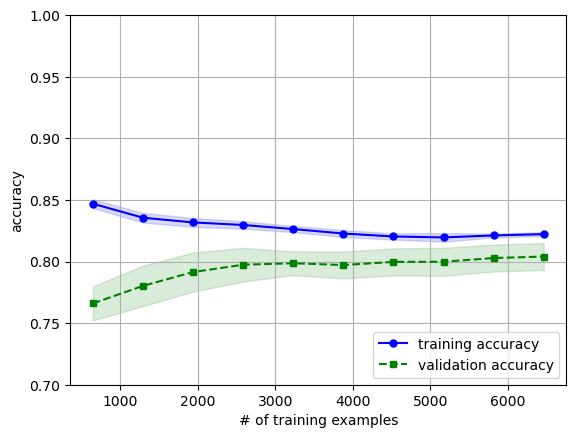

In [124]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y = y_train, train_sizes=np.linspace(0.1,1.0,10), cv = 8, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std,train_mean-train_std, alpha = 0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green',linestyle = '--' ,marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std,test_mean-test_std, alpha = 0.15, color='green')

plt.grid()
plt.xlabel('# of training examples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7,1])
plt.show()

orginally with no params showed high degree of over fitting and variance CV was not the issue as both higher and lower numbers show the same convergence with a high differance however adding these params did not change the validation accuracy but affected the training accuracy to look like the image above max_depth=4,subsample=0.8,eval_metric="logloss"

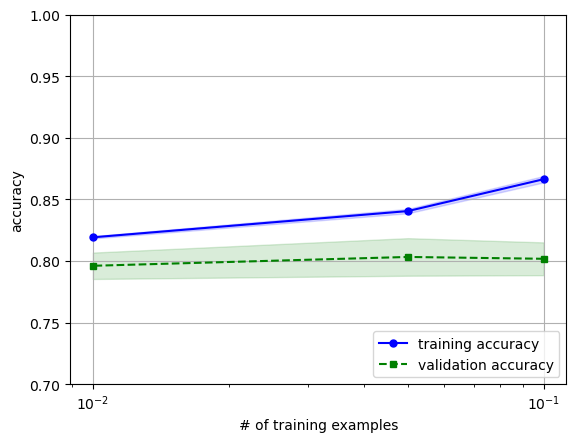

In [57]:
from sklearn.model_selection import validation_curve
param_range = [0.1,0.05,0.01]
train_scores2, test_scores2 = validation_curve(estimator=pipe,X = X_train, y = y_train, param_name='xgbclassifier__learning_rate', param_range=param_range, cv =10)

train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)

plt.plot(param_range, train_mean2, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean2+train_std2,train_mean2-train_std2, alpha = 0.15, color='blue')

plt.plot(param_range, test_mean2, color='green',linestyle = '--' ,marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean2+test_std2,test_mean2-test_std2, alpha = 0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('# of training examples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7,1])
plt.show()

In [154]:
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(2)

param_grid = {
    'xgbclassifier__learning_rate': [0.1, 0.2],
    'xgbclassifier__max_depth': [5, 7],
    'xgbclassifier__n_estimators': [50, 100],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
    'xgbclassifier__min_child_weight': [5, 7],
    'xgbclassifier__reg_alpha': [0.1],
    'xgbclassifier__reg_lambda': [10]
}

rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring='accuracy', refit=True, n_iter=50, cv=6,random_state=1,n_jobs=-1)

randserch = rs.fit(X_train, y_train)
print(rs.best_score_)


0.8030876684918113


In [133]:
print(randserch.best_params_)

{'xgbclassifier__subsample': 1.0, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__colsample_bytree': 0.8}


In [135]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(
    pipe,
    param_distributions=param_grid,
    factor=1.5,
    resource='n_samples',
    random_state=1,
    n_jobs=-1
)

hs.fit(X_train, y_train)
print(hs.best_score_)

/Users/The_real_G/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 64 is smaller than n_iter=369. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7982608695652174


In [134]:
from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=10,
    n_jobs=-1
    )

gs.fit(X_train, y_train)
print(gs.best_score_)


0.7993540160729655


In [194]:
from sklearn.metrics import accuracy_score

y_pred = rs.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8052147239263804


best testing accuracy up by about 1% with a lower deviation

In [147]:
test_df = pd.read_csv('test.csv')

# set up for further filtering
test_df['NameLength'] = test_df['Name'].str.len()
test_df['Cabin'] = test_df['Cabin'].astype(str)
test_df['Cabin'] = test_df['Cabin'].str[0] + test_df['Cabin'].str[-1]
test_df['total spending'] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_df['VIP'] = test_df['VIP'].fillna(False).astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].fillna(False).astype(int)


# Apply the exact same mappings to your new dataset
test_df['HomePlanet'] = test_df['HomePlanet'].map(planet_map)
test_df['Destination'] = test_df['Destination'].map(d_map)
test_df['Cabin_ordinal'] = test_df['Cabin'].map(cabin_mapping).fillna(-1).astype(int)

#drop unused Catagories
tested_X = test_df[['HomePlanet', 'CryoSleep', 'Age','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','NameLength', 'total spending', 'Cabin_ordinal']]

tested_X = tested_X.fillna(tested_X.median())

tested_X

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NameLength,total spending,Cabin_ordinal
0,2.0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0
1,2.0,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,14.0,2832.0,1
2,0.0,1,31.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,5
3,0.0,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,16.0,7418.0,5
4,2.0,0,20.0,0,10.0,0.0,635.0,0.0,0.0,15.0,645.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,2.0,1,34.0,0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0
4273,2.0,0,42.0,0,0.0,847.0,17.0,10.0,144.0,13.0,1018.0,12
4274,1.0,1,26.0,0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,11
4275,0.0,0,26.0,0,0.0,2680.0,0.0,0.0,523.0,14.0,3203.0,11


In [195]:
from scipy.stats import mode

preds = np.array([model.predict(X_test) for model in models])
# Convert boolean to int (True->1, False->0)
preds = preds.astype(int)

majority_vote_preds, _ = mode(preds, axis=0)
majority_vote_preds = majority_vote_preds.ravel()

ensemble_accuracy = accuracy_score(y_test, majority_vote_preds)
print(f'Ensemble accuracy by majority voting: {ensemble_accuracy:.4f}')

Ensemble accuracy by majority voting: 0.8137


In [ ]:
passenger_ids = test_df['PassengerId']
comb_preds = np.array([model.predict(tested_X) for model in models])
comb_preds = comb_preds.astype(int)
majority_voted_preds, _ = mode(comb_preds, axis=0)
majority_voted_preds = majority_voted_preds.ravel()

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],      # make sure this aligns with tested_X rows  
    'Transported': False
})


submission.to_csv('submission_majority_vote_V3.csv', index=False)

In [ ]:
passenger_ids = test_df['PassengerId']
guesses = rs.predict(tested_X)
submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': guesses.astype(bool)
    })

submission.to_csv('submission3.csv', index=False)

right now 

1: 79.84
2: 80.007
3(majority vote): 80.5
4(v2): 80.29
5:(v3): 79.518
6:past voting: 80.3

In [ ]:
probs = rs.predict_proba(tested_X)
prob_true = probs[:, 1]
distance_from_50 = abs(prob_true - 0.5)
df = pd.DataFrame(distance_from_50, index=passenger_ids, columns=['DistanceFrom50'])
df_sorted = df.sort_values(by='DistanceFrom50')
count_below_005 = (df['DistanceFrom50'] < 0.05).sum()
print(f"Number of predictions with confidence distance below 0.05: {count_below_005}")

Number of predictions with confidence distance below 0.05: 289


In [199]:
import pandas as pd
import numpy as np
from scipy.stats import mode

# Paths to your 5 CSV prediction files
csv_files = [
    'submission1.csv',
    'submission2.csv',
    'submission_majority_vote.csv',
    'submission_majority_vote_v2.csv',
    'submission_majority_vote_v3.csv'
]

dfs = [pd.read_csv(f) for f in csv_files]

# Confirm all PassengerId columns are identical (or align them)
for df in dfs[1:]:
    assert (dfs[0]['PassengerId'] == df['PassengerId']).all(), "PassengerIds don't match!"

# Stack the predictions from all files (convert bool to int if needed)
preds_array = np.array([df['Transported'].astype(int).values for df in dfs])

# Majority vote (mode) across the 5 models, axis=0 means per sample
majority_vote_preds, _ = mode(preds_array, axis=0)
majority_vote_preds = majority_vote_preds.ravel()

# Build submission dataframe
submission = pd.DataFrame({
    'PassengerId': dfs[0]['PassengerId'],
    'Transported': majority_vote_preds.astype(bool)
})

submission.to_csv('ensemble_submission.csv', index=False)
print("Ensembled submission saved as ensemble_submission.csv")


Ensembled submission saved as ensemble_submission.csv
